<a href="https://colab.research.google.com/github/romerofernandes/power_consumption_predict/blob/main/power_consumption_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importações

###Bibliotecas

In [172]:
#Analise de dados
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import StandardScaler

In [173]:
#Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [174]:
#Função para colocar os valores sobre as barras nos gráficos de barras
def values_text(graf):
    for bar in graf.patches:
        graf.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() * 1.01,
            round(bar.get_height(),1),
            horizontalalignment='center',
            color= 'black'
            )

In [175]:
#Modelagem
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, r_regression

In [176]:
#! pip install scikit-optimize

In [177]:
#Otimização de hiperparametros 
#Necessario instalar scikit-optimize: ! pip install scikit-optimize
#from skopt import BayesSearchCV
#from skopt.space import Integer

In [178]:
#Modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [179]:
#Análise dos modelos
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

###Dados

####Dados de consumo

In [180]:
#Dados sobre o consumo de energia elétrica

df_consumption = pd.read_csv('/content/power_usage_2016_to_2020.csv', 
                             parse_dates= ['StartDate'])

In [181]:
df_consumption.head()

StartDate  Value (kWh)  day_of_week    notes
0 2016-01-06 00:00:00        1.057            2  weekday
1 2016-01-06 01:00:00        1.171            2  weekday
2 2016-01-06 02:00:00        0.560            2  weekday
3 2016-01-06 03:00:00        0.828            2  weekday
4 2016-01-06 04:00:00        0.932            2  weekday

In [182]:
df_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35952 entries, 0 to 35951
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   StartDate    35952 non-null  datetime64[ns]
 1   Value (kWh)  35952 non-null  float64       
 2   day_of_week  35952 non-null  int64         
 3   notes        35952 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.1+ MB


In [183]:
#Verificando registros duplicados
print(f"Valores duplicados: {df_consumption.duplicated().sum()}")

Valores duplicados: 0


In [184]:
df_consumption.notes.unique()

array(['weekday', 'weekend', 'vacation', 'COVID_lockdown'], dtype=object)

In [185]:
df_consumption.drop(columns=['notes','day_of_week'], inplace=True)

In [186]:
df_consumption.sort_values(by='StartDate').head()

StartDate  Value (kWh)
0 2016-01-06 00:00:00        1.057
1 2016-01-06 01:00:00        1.171
2 2016-01-06 02:00:00        0.560
3 2016-01-06 03:00:00        0.828
4 2016-01-06 04:00:00        0.932

In [187]:
#Renomeando a coluna de consumo
df_consumption.rename(columns={'Value (kWh)': 'consumption', 'StartDate':'Date'}, inplace=True)

In [188]:
df_consumption = df_consumption.groupby(df_consumption.Date.dt.date).sum().reset_index()

In [189]:
df_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498 entries, 0 to 1497
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1498 non-null   object 
 1   consumption  1498 non-null   float64
dtypes: float64(1), object(1)
memory usage: 23.5+ KB


In [190]:
df_consumption.Date = pd.to_datetime(df_consumption.Date)

In [191]:
df_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498 entries, 0 to 1497
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1498 non-null   datetime64[ns]
 1   consumption  1498 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 23.5 KB


In [192]:
df_consumption.describe()

consumption
count  1498.000000
mean     21.399148
std      12.635139
min       4.610000
25%      10.828750
50%      16.833500
75%      30.726250
max      78.225300

####Dados sobre o tempo

In [193]:
#Dados sobre tempo (temperatura, pressão, preciptação...)
df_weather = pd.read_csv('/content/weather_2016_2020_daily.csv', parse_dates=['Date'])

In [194]:
df_weather.head()

Date  Day  Temp_max  Temp_avg  Temp_min  Dew_max  Dew_avg  Dew_min  \
0 2016-01-06    1        85      74.8        68       74     71.4       66   
1 2016-02-06    2        76      71.2        66       74     70.3       66   
2 2016-03-06    3        79      72.1        68       72     70.0       68   
3 2016-04-06    4        76      71.2        69       73     70.0       66   
4 2016-05-06    5        82      73.8        68       72     70.0       68   

   Hum_max  Hum_avg  Hum_min  Wind_max  Wind_avg  Wind_min  Press_max  \
0      100     89.4       65        21       9.5         0       29.8   
1      100     96.8       89        18       7.8         0       29.8   
2      100     93.6       72        18       4.7         0       29.8   
3      100     96.1       85        20       7.0         0       29.8   
4      100     88.7       62        17       7.7         0       29.7   

   Press_avg  Press_min  Precipit  day_of_week  
0       29.8       29.7      0.00            2  
1       29.8       29.7      4.33            5  
2       29.8       29.7      3.18            6  
3       29.7       29.7      2.37            2  
4       29.7       29.7      0.39            4

In [195]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1552 entries, 0 to 1551
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1552 non-null   datetime64[ns]
 1   Day          1552 non-null   int64         
 2   Temp_max     1552 non-null   int64         
 3   Temp_avg     1552 non-null   float64       
 4   Temp_min     1552 non-null   int64         
 5   Dew_max      1552 non-null   int64         
 6   Dew_avg      1552 non-null   float64       
 7   Dew_min      1552 non-null   int64         
 8   Hum_max      1552 non-null   int64         
 9   Hum_avg      1552 non-null   float64       
 10  Hum_min      1552 non-null   int64         
 11  Wind_max     1552 non-null   int64         
 12  Wind_avg     1552 non-null   float64       
 13  Wind_min     1552 non-null   int64         
 14  Press_max    1552 non-null   float64       
 15  Press_avg    1552 non-null   float64       
 16  Press_

In [196]:
#Verificando registros duplicados
print(f"Valores duplicados: {df_weather.duplicated().sum()}")

Valores duplicados: 0


###Dataset para modelagem

In [197]:
df_cons_pred = df_weather.merge(df_consumption, on='Date', how='right')

In [198]:
df_cons_pred.isnull().sum()

Date           0
Day            0
Temp_max       0
Temp_avg       0
Temp_min       0
Dew_max        0
Dew_avg        0
Dew_min        0
Hum_max        0
Hum_avg        0
Hum_min        0
Wind_max       0
Wind_avg       0
Wind_min       0
Press_max      0
Press_avg      0
Press_min      0
Precipit       0
day_of_week    0
consumption    0
dtype: int64

In [199]:
#Verificando registros duplicados
print(f"Valores duplicados: {df_cons_pred.duplicated().sum()}")

Valores duplicados: 0


##Analises dos dados

###Analise correlação

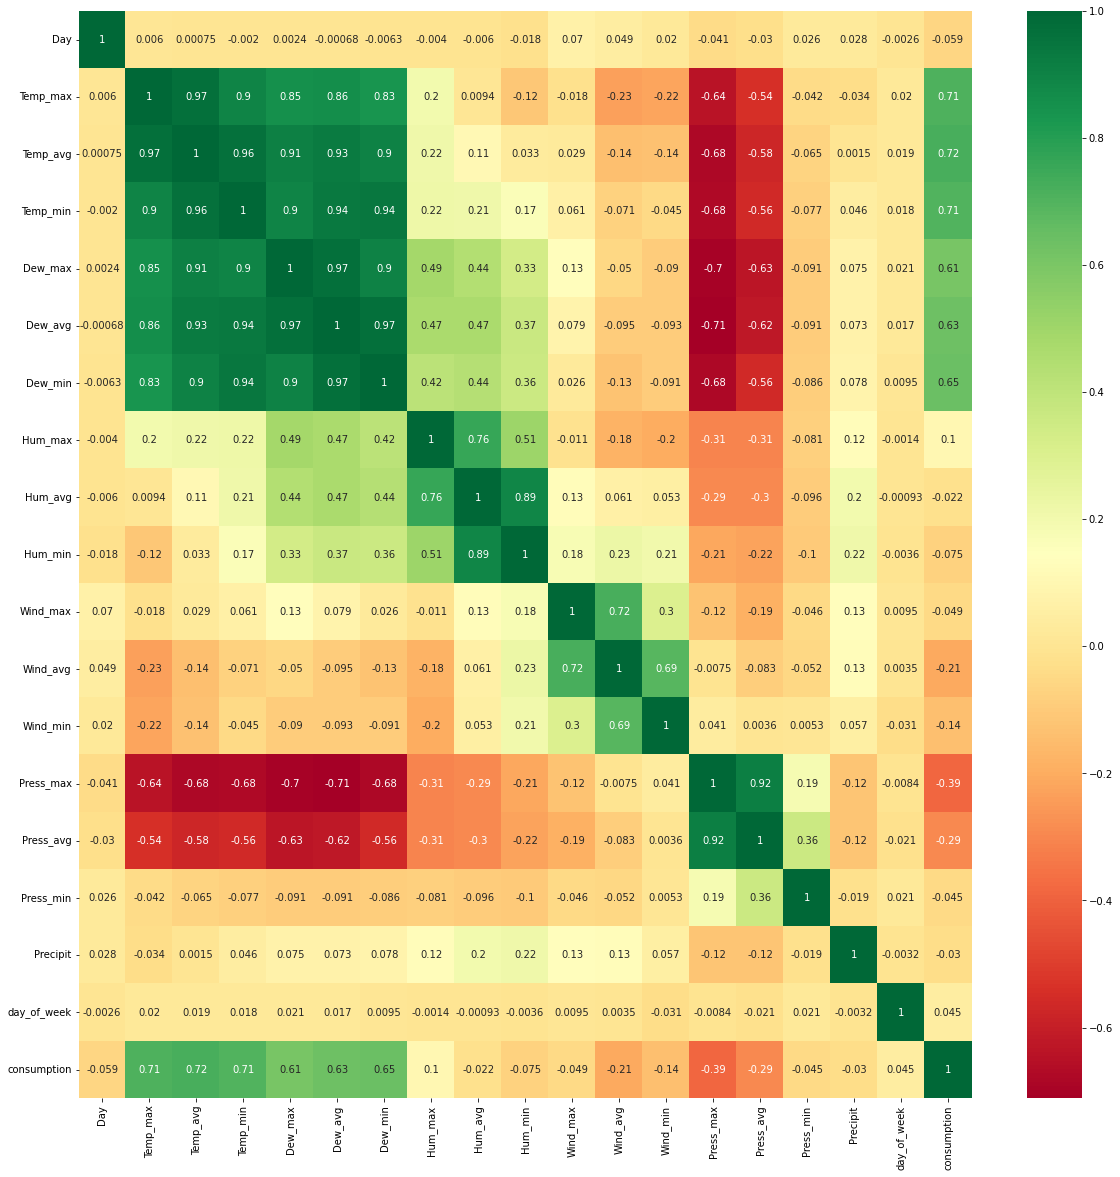

In [ ]:
#correlacao linear
#get correlations of each features in dataset
corrmat = df_cons_pred.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df_cons_pred[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [158]:
# Avaliação das features aplicando o teste Anova
test = SelectKBest(score_func=f_regression)
fit = test.fit(df_cons_pred[df_cons_pred.columns[1:-1]], df_cons_pred['consumption'])

#print das features e seus respectivos p-value
for value in [*zip(X.columns, fit.pvalues_)]:
  
  print(value)

('Day', 0.02307587877892945)
('Temp_max', 9.787346470938972e-231)
('Temp_avg', 8.575695445540766e-240)
('Temp_min', 1.0208785012429173e-225)
('Dew_max', 3.0192689734113702e-151)
('Dew_avg', 2.4063940564508213e-169)
('Dew_min', 4.747554460791973e-177)
('Hum_max', 9.809408408638186e-05)
('Hum_avg', 0.3895945857328085)
('Hum_min', 0.003578418223692525)
('Wind_max', 0.05633927476971117)
('Wind_avg', 2.2831581020724233e-16)
('Wind_min', 1.0559494635599866e-07)
('Press_max', 2.4677375339118303e-54)
('Press_avg', 1.176147839122526e-30)
('Press_min', 0.08464057152908021)
('Precipit', 0.24682356792980018)
('day_of_week', 0.07862960619337575)


In [200]:
columns = ['Date','Temp_max', 'Temp_avg', 'Temp_min', 'Dew_max', 'Dew_avg', 'Dew_min', 'Hum_max', 'Hum_min', 'Wind_avg', 'Wind_min', 'Press_max', 'Press_avg', 'consumption']

In [201]:
df_cons_pred = df_cons_pred[columns]

###Analise de escala

In [29]:
columns = df_cons_pred.columns.values
columns

array(['Date', 'Day', 'Temp_max', 'Temp_avg', 'Temp_min', 'Dew_max',
       'Dew_avg', 'Dew_min', 'Hum_max', 'Hum_avg', 'Hum_min', 'Wind_max',
       'Wind_avg', 'Wind_min', 'Press_max', 'Press_avg', 'Press_min',
       'Precipit', 'day_of_week', 'consumption'], dtype=object)

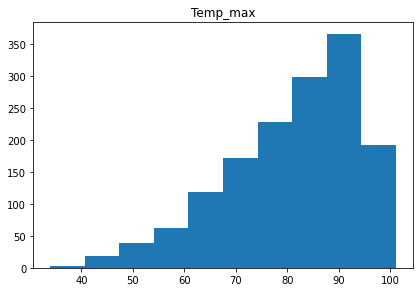

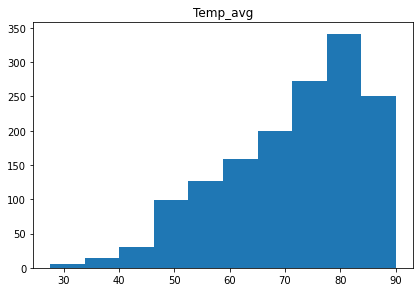

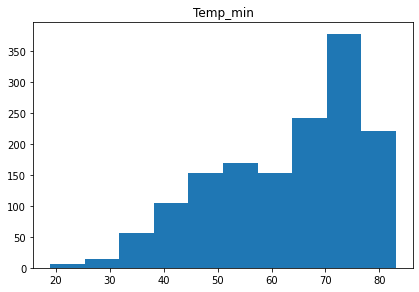

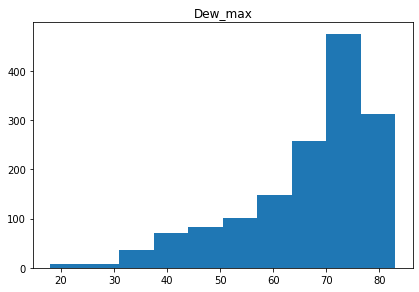

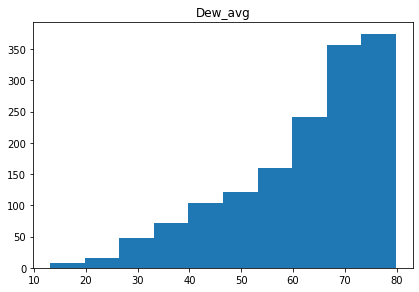

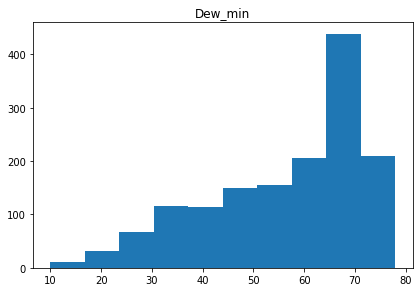

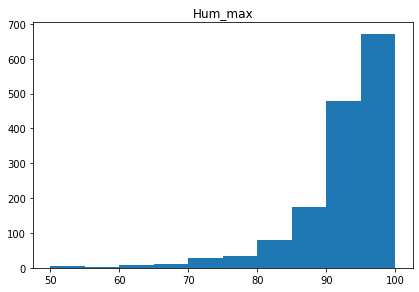

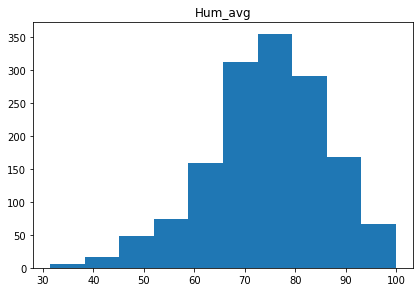

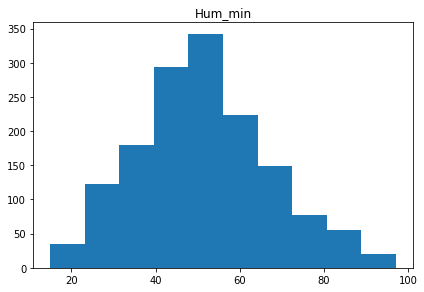

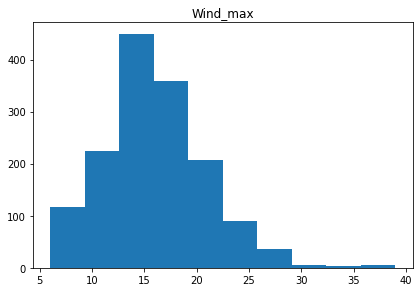

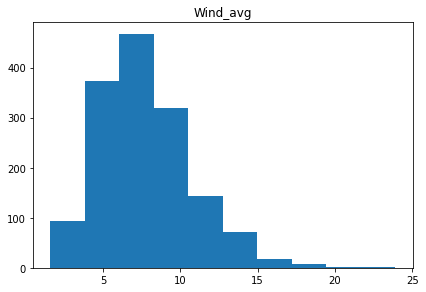

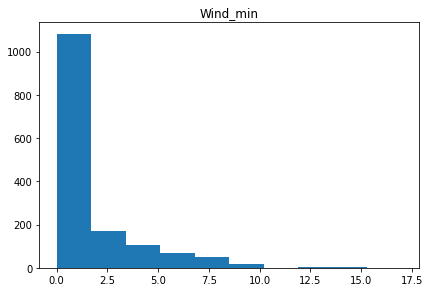

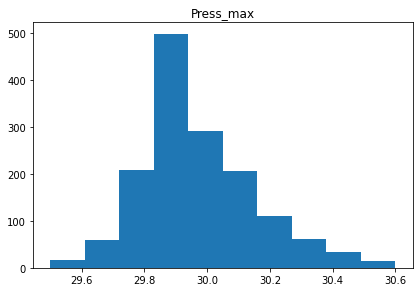

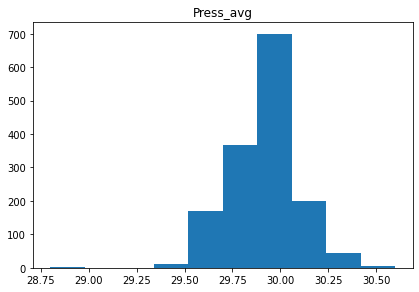

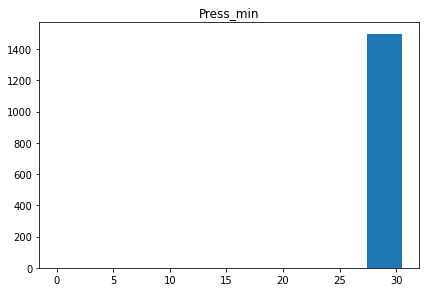

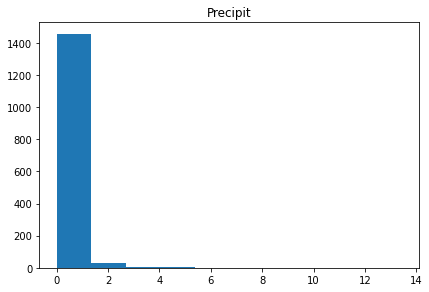

In [30]:
for feature in columns[2:-2]:
  fig, ax = plt.subplots()
  fig.tight_layout()
  ax.hist(x=df_cons_pred[feature])
  ax.set_title(feature)

In [ ]:
scaler = StandardScaler()


##Feature engineering

In [202]:
df_cons_pred['day'] = df_cons_pred.Date.dt.day
df_cons_pred['day_of_week'] = df_cons_pred.Date.dt.day_of_week
df_cons_pred['month'] = df_cons_pred.Date.dt.month
df_cons_pred['year'] = df_cons_pred.Date.dt.year
df_cons_pred.drop(columns='Date', inplace=True)

In [203]:
df_cons_pred.head()

Temp_max  Temp_avg  Temp_min  Dew_max  Dew_avg  Dew_min  Hum_max  Hum_min  \
0        85      74.8        68       74     71.4       66      100       65   
1        94      84.9        76       76     74.0       72       94       51   
2        97      86.5        75       76     73.3       67       96       37   
3        96      86.2        78       75     73.3       70       88       46   
4        81      71.1        61       64     59.4       57       90       45   

   Wind_avg  Wind_min  Press_max  Press_avg  consumption  day  day_of_week  \
0       9.5         0       29.8       29.8       29.691    6            2   
1       5.7         0       29.9       29.9       43.177    7            3   
2       6.0         0       30.0       29.9       50.057    8            4   
3       6.3         0       29.8       29.8       47.363    9            5   
4       3.3         0       30.0       29.9       42.203   10            6   

   month  year  
0      1  2016  
1      1  2016  
2      1  2016  
3      1  2016  
4      1  2016

In [204]:
# Definindo a função Dummies
def dummies(x,df):
    
    #cria um dataframe temporario com o resultado do processo One-hot Encode e deletando a primeira coluna
    temp = pd.get_dummies(df[x], drop_first = True)
    
    #concatena o dataframe df com o temporario
    df = pd.concat([df, temp], axis = 1)
    
    #exclui a coluna referente ao atributo x
    df = df.drop(columns = x)
    
    return df

In [205]:
var_categ = ['day',	'day_of_week',	'month',	'year']

In [206]:
#aplica a função dummies para os atributos categoricos
for var in var_categ:
    df_cons_pred = dummies(var,df_cons_pred)

In [207]:
df_cons_pred.head()

Temp_max  Temp_avg  Temp_min  Dew_max  Dew_avg  Dew_min  Hum_max  Hum_min  \
0        85      74.8        68       74     71.4       66      100       65   
1        94      84.9        76       76     74.0       72       94       51   
2        97      86.5        75       76     73.3       67       96       37   
3        96      86.2        78       75     73.3       70       88       46   
4        81      71.1        61       64     59.4       57       90       45   

   Wind_avg  Wind_min  ...  7  8  9  10  11  12  2017  2018  2019  2020  
0       9.5         0  ...  0  0  0   0   0   0     0     0     0     0  
1       5.7         0  ...  0  0  0   0   0   0     0     0     0     0  
2       6.0         0  ...  0  0  0   0   0   0     0     0     0     0  
3       6.3         0  ...  0  0  0   0   0   0     0     0     0     0  
4       3.3         0  ...  0  0  0   0   0   0     0     0     0     0  

[5 rows x 64 columns]

##Testes

In [219]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from sklearn.metrics import r2_score

In [230]:
X = df_cons_pred.drop(columns=['consumption'])
y = df_cons_pred.consumption

In [231]:
X_columns = X.columns

In [232]:
scaler = StandardScaler()

In [234]:
X = StandardScaler().fit_transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [211]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

In [212]:
LM = LinearRegression()

In [213]:
LM.fit(X_train, y_train)

LinearRegression()

In [214]:
r2_score(y_test, LM.predict(X_test))

0.6547934967949378

In [215]:
RFR = RandomForestRegressor()

In [216]:
RFR.fit(X_train, y_train)

RandomForestRegressor()

In [217]:
r2_score(y_test, RFR.predict(X_test))

0.7817787539771978

In [220]:
Lasso = LassoCV()

In [221]:
Lasso.fit(X_train, y_train)

LassoCV()

In [224]:
Lasso.score(X_test, y_test)

0.6531843099160066

In [225]:
Lasso.coef_

array([ 1.62950818e+00,  1.36856332e+00,  3.79573255e+00, -0.00000000e+00,
        0.00000000e+00,  3.47696957e-01, -7.79850448e-02, -1.36673268e+00,
       -2.61231026e-01,  0.00000000e+00,  1.18639528e-03,  3.71430875e-01,
       -2.71822929e-01, -8.43836052e-01, -7.34215550e-01, -2.71053709e-01,
        8.79148952e-01,  1.40723107e+00,  1.11522649e+00,  2.90304265e-01,
        7.57998881e-01, -4.17229451e-01, -2.83992461e-01,  3.78951757e-01,
        3.65027501e-01,  4.16472278e-01,  0.00000000e+00,  2.09344331e-02,
        1.51400807e-01,  0.00000000e+00,  1.66839573e-01, -0.00000000e+00,
       -0.00000000e+00, -1.60642533e-01, -2.45552484e-01, -3.16762755e-01,
       -4.21439028e-01, -1.83254977e-01, -0.00000000e+00, -7.32814077e-02,
        0.00000000e+00, -0.00000000e+00, -7.95579786e-02, -0.00000000e+00,
        3.36357009e-02, -7.17972798e-02,  1.65491816e-01,  1.77901961e-01,
       -3.04499788e-01, -8.43050914e-01, -4.95489944e-01,  3.62159578e-02,
        1.21256589e+00,  

In [235]:
#print das features e seus respectivos p-value
for value in [*zip(X_columns, Lasso.coef_)]:
  print(value)

('Temp_max', 1.6295081838911252)
('Temp_avg', 1.3685633194197984)
('Temp_min', 3.795732553719301)
('Dew_max', -0.0)
('Dew_avg', 0.0)
('Dew_min', 0.34769695655784766)
('Hum_max', -0.07798504478690281)
('Hum_min', -1.3667326796486703)
('Wind_avg', -0.26123102630725314)
('Wind_min', 0.0)
('Press_max', 0.0011863952800133483)
('Press_avg', 0.3714308750419818)
(2, -0.27182292947469583)
(3, -0.8438360515256619)
(4, -0.7342155503711952)
(5, -0.2710537093435635)
(6, 0.8791489522392015)
(7, 1.407231070078969)
(8, 1.1152264902716942)
(9, 0.2903042646868856)
(10, 0.7579988805646224)
(11, -0.4172294512175706)
(12, -0.2839924611558189)
(13, 0.3789517572274063)
(14, 0.36502750117330346)
(15, 0.41647227829388556)
(16, 0.0)
(17, 0.020934433088997197)
(18, 0.1514008065543257)
(19, 0.0)
(20, 0.16683957336808097)
(21, -0.0)
(22, -0.0)
(23, -0.16064253302823323)
(24, -0.2455524841857677)
(25, -0.31676275541319304)
(26, -0.4214390275019427)
(27, -0.18325497695025608)
(28, -0.0)
(29, -0.0732814076981772)
(30